In [1]:
import pandas as pd
import numpy as np
import re, os

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
jet = plt.get_cmap('jet')


import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from statsmodels.regression.linear_model import WLS
from statsmodels.stats.weightstats import ttest_ind
from statsmodels.discrete.discrete_model import Probit
from statsmodels.discrete.discrete_model import Logit
from statsmodels.regression.quantile_regression import QuantReg
from scipy.stats import norm
from scipy.stats import lognorm
from scipy.stats import ks_2samp
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneOut
from scipy.stats import gaussian_kde

from statsmodels.discrete.discrete_model import Poisson
from patsy import dmatrix
from scipy import integrate

import itertools
data_path = "C:/Users/SpiffyApple/Documents/USC/OwnResearch/proposal"

In [2]:
#convenience function
def toLatex(tmpDF, file_name, regOut = False):
    if regOut == False:
        with open("/".join([data_path,file_name]), 'w+') as f:
            f.write(tmpDF.to_latex())
    if regOut:
        with open("/".join([data_path,file_name]), 'w+') as f:
            f.write(tmpDF.as_latex())
    return(tmpDF)

def toExcel(tmpDF, file_name):
    tmpDF.to_excel("/".join([data_path,file_name]))
    return(tmpDF)

In [3]:
def runRegression(y,x,data):
    form = '{0} ~ {1}'.format(y,x)
    mod = smf.ols(formula=form, data=data)
    res = mod.fit()#cov_type='HC0')
    return(res)


def runQuantRegression(y,x,data,quant=.5):
    form = '{0} ~ {1}'.format(y,x)
    mod = smf.quantreg(formula=form, data=data)
    res = mod.fit(quant=.5)#cov_type='HC0')
    return(res)

def processParams(params, cont):
    if type(params) is list:
        paramsDict = {}
        for param in params:
            paramsDict[param] = cont.params[param]
        paramsDict['nobs'] = cont.nobs
        paramsDict['R^2 adj'] = cont.rsquared_adj
        
        return(paramsDict)
    
    if type(params) is str:
        return({'delta':cont.params[params], 'nObs':cont.nobs,'R^2 adj':cont.rsquared_adj})
        
def extractResults(varsIntrst, fitDict, condNum=True, params = None):
    outDict = {}    
    paramsDict = {}
    outDictparams = {}
    for key in fitDict.keys():
        tmpDict = {}
        cont = fitDict[key]

        for var in varsIntrst:
            try:
                tmpDict[var] = "%.03f (%.03f)" %(cont.params[var], cont.pvalues[var]) 
            except KeyError as e:
                tmpDict[var] = ''
                        
        tmpDict['nObs'] = cont.nobs
        tmpDict['R^2 adj'] = cont.rsquared_adj.round(2)
        
        outDict[key] = tmpDict
        
        if condNum==True:
            tmpDict['condNum'] = cont.condition_number.round(0)

        if params:
            outDictparams[key] = processParams(params,cont)    

    if params:
        return([pd.DataFrame(outDict),pd.DataFrame(outDictparams).transpose()])
    else:
        return(pd.DataFrame(outDict))

# Load Case-Shiller data

Data come from St. Louis Federal [Reserve](https://fred.stlouisfed.org/series/CSUSHPISA)

In [4]:
cs = pd.read_csv("/".join([data_path, 'CSUSHPINSA1987-2014.csv']))

In [5]:
# format years
cs.loc[:,'date'] = pd.to_datetime(cs.DATE)
cs.loc[:,'year'] = cs.date.dt.year

In [6]:
csYear = cs.groupby('year').CSUSHPINSA.mean()

# Load xwalk between CBSA and SMSA Codes

Data come from [NBER](https://data.nber.org/data/cbsa-msa-fips-ssa-county-crosswalk.html)

In [7]:
xw = pd.read_excel("/".join([data_path, 'FR05_CBSA_MSA_XWALK_pub.xls']))

#clean up the columns
xw.columns = xw.columns.str.replace(" - [\w\s\(\)\d]+",'').str.strip()

xw.dtypes

County Name      object
ST               object
SSACD             int64
FIPSCD            int64
Old MSA          object
OldMSA Name      object
New MSA         float64
New MSA Name     object
dtype: object

# Load HPI data
Data come from [FHFA](https://www.fhfa.gov/DataTools/Downloads/Pages/House-Price-Index.aspx)

In [8]:
# load data
hpi_state = pd.read_csv("/".join([data_path, 'HPI_at_state.txt']),sep='\t',header=None)
hpi_metro = pd.read_csv("/".join([data_path, 'HPI_at_metro.txt']),sep='\t',header=None)


# set columns
hpi_state.columns = ['state','year','quarter','hpi']
hpi_metro.columns = ['metro','code','year','quarter','hpi','q2q_change']

hpi_state = hpi_state.loc[hpi_state.hpi != '.']
hpi_state.loc[:,'hpi'] = hpi_state.hpi.astype(np.float)
hpi_metro.loc[:,'hpi'] = hpi_metro.hpi.replace("-",np.nan).astype('float')

In [9]:
# merge x-walk with HPI data
hpi_metro = hpi_metro.merge(xw,left_on='code',right_on = 'New MSA',how='left')

In [10]:
# simplify because we don't need quarterly data.
# take avg at state and year levels
hpi_state = hpi_state.groupby(['state','year']).hpi.mean()
hpi_state.name = 'hpi'

# take 2nd quarter from hpi_metro (could avg but not feeling it)
#hpi_metro = hpi_metro.loc[hpi_metro.quarter==2]

# alternatively...
hpi_metro.loc[:,'avg_hpi'] = hpi_metro.groupby(['metro','year']).hpi.transform('mean')
hpi_metro = hpi_metro.loc[hpi_metro.quarter==1]
hpi_metro.drop('quarter',axis=1,inplace=True)

# Load CPI Data

Data come from [BLS](https://www.bls.gov/cpi/data.htm)
Some [info](https://download.bls.gov/pub/time.series/cw/cw.txt) on the periods (M13)

Info on the types of [series](https://download.bls.gov/pub/time.series/cw/cw.series) in the data. For example, CWUR0000SAH is the U.S. avg housing for urban wage and clerical workers (no seasonally adjusted) while ...SAH1 is for shelter, ...SAH2 is for fuel, AH3 is for furniture, etc. Similarly, CWUR0100SA0L2 is CPI for all items less shelter (which is what I want to use) while CWUR0000SA0 is all item US avg. (which is what I use) - neither are seasonally adjusted


In [11]:
cpi_housing = pd.read_csv('/'.join([data_path, 'cw.data.12.USHousing.txt']),sep='\t')
cpi_all = pd.read_csv("/".join([data_path, 'cw.data.1.AllItems.txt']),sep='\t')

cpi_all.columns = cpi_all.columns.str.strip()
cpi_housing.columns = cpi_housing.columns.str.strip()

In [12]:
# footnotes seems empty:
print("are footnotes empty?:",cpi_all.footnote_codes.isnull().all())
cpi_all.drop('footnote_codes',axis=1,inplace=True)
cpi_housing.drop('footnote_codes',axis=1,inplace=True)

are footnotes empty?: True


In [13]:
cpi_all.series_id.str.contains('CWUR0000SA0').any()

True

In [14]:
# keep annual average (M13)
cpi_all = cpi_all.loc[cpi_all.period == 'M13']
cpi_housing = cpi_housing.loc[cpi_housing.period == 'M13']

cpi_all.drop('period',axis=1,inplace=True)
cpi_housing.drop('period',axis=1,inplace=True)

In [15]:
# select overall housing CPI and CPI for all items [later less shelter]
cpi_housing = cpi_housing.loc[cpi_housing.series_id.str.strip() == "CWUR0000SAH"].drop('series_id',axis=1)
cpi_all = cpi_all.loc[cpi_all.series_id.str.strip()=='CWUR0000SA0'].drop('series_id',axis=1)

In [16]:
# merge the two series after renaming columns
cpi_all.rename(columns = {'value':'cpi_all'},inplace=True)
cpi_housing.rename(columns = {'value':'cpi_housing'},inplace=True)
cpi = cpi_all.merge(cpi_housing,on='year')

# Load Mortgage rate data

30-year fixed rate mortgage [data](https://fred.stlouisfed.org/graph/?g=NUh) come from St. Louis Federal Reserve

In [17]:
intrs = pd.read_csv("/".join([data_path,'MORTGAGE30US.csv']))

# format the dates
intrs.loc[:,'date'] = pd.to_datetime(intrs.DATE)
intrs.loc[:,'year'] = intrs.date.dt.year

# acquire the year average
r = intrs.groupby('year').MORTGAGE30US.mean()/100 

# Load Rosenthal Rent data

Below, I use the 1985-2011 data from the Rosenthal's 2014 AER paper, *Are Private Markets and Filtering a Viable Source of Low-Income Housing? Estimates from a "Repeat Income" Model."*

I get the data from the [replication data](https://www.openicpsr.org/openicpsr/project/112738/version/V1/view) on the AER website. 

I use these data purely out of convenience. To get 1985-1997 data, one has to ask for a disc from the AHS and the further processing is a headache to I lean on Rosenthal's contribution. According to the [AHS](https://www2.census.gov/programs-surveys/ahs/documentation/2015-2017_Sample_Case_History_Readme.pdf), they survey the same units every year unless the units disappear so one can construct a longitudinal data set from the units and biannually observe their rents. Technically, Rosenthal's panel could be extended to 2013 because the AHS panel runs from 1985-2013 (while the new one runs 2015+) but I don't add the 2013 survey here. To get the data, I had to run the STATA programs included in the folder. The programs from which I get the data mostly merge the raw datasets (I say raw, they are all actually in STATA .dta format) and put them into a single renter sample. Rosenthal does a few things with the data for formatting and munging purposes (ie he makes an *annual* panel for every unit which unnecessarily bloats the set) because of STATA's programming limitations but I either undo those additions or ignore them. 

In [18]:
# find relevant file
f = [s for s in os.listdir("/".join([data_path, 'postfolder','data','temp'])) if '3c_2_rent' in s.lower()]

In [19]:
# load data
filename = "/".join([data_path, 'postfolder','data','temp',f[0]])
df = pd.read_stata(filename)

In [20]:
# drop units for which no rents are ever observed
cntrls = df.groupby('control').rent.apply(lambda x: x.notnull().sum())
df = df.loc[~df.control.isin(cntrls[cntrls==0].index)]

In [21]:
# drop data that are all NA
df.drop(df.columns[df.isnull().all()],axis=1,inplace=True)

In [22]:
# drop units for which only 2 are rents are observed
cntrls = df.groupby('control').rent.apply(lambda x: x.notnull().sum())
df = df.loc[~df.control.isin(cntrls[cntrls<2].index)]

In [23]:
df.drop(df[df.rent.isnull()].index,inplace=True)

# Real rents

In [24]:
# merge with CPI
df = df.merge(cpi,on='year',how='left')

In [25]:
# adjust prices
df.loc[:,'rrent'] = df.rent/(df.cpi_all/100)
df.loc[:,'rrent_updated'] = df.rent_updated/(df.cpi_all/100)

# Create variables

In [26]:
# is there an MSA variable?
df.columns[df.columns.str.lower().str.contains("msa")]

Index(['smsa', 'ccmsa', 'msaurb', 'msarur', 'nmsaurb', 'nmsarur'], dtype='object')

In [27]:
# insert updated rents into rent field
df.loc[df.rent_updated>df.rent,'rent'] = df.loc[df.rent_updated>df.rent,'rent_updated']
df.loc[df.rrent_updated>df.rrent,'rrent'] = df.loc[df.rent_updated>df.rent,'rrent_updated']

In [28]:
# create variable change
df.loc[:,'rent_tminus'] = df.groupby('control').rent.shift(1) #nominal
df.loc[:,'rrent_tminus'] = df.groupby('control').rrent.shift(1) #real

df.loc[:,'rentChange'] = np.log(df.rent/df.rent_tminus) #nominal
df.loc[:,'rrentChange'] = np.log(df.rrent/df.rrent_tminus) #real

df.loc[:,['control','year','rent','rent_tminus','rentChange','rrent','rrentChange','firstRent']].head(n=10)

C:\Users\SpiffyApple\Anaconda3\lib\site-packages\pandas\core\indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


,control,year,rent,rent_tminus,rentChange,rrent,rrentChange,firstRent
0,1.000071e+11,1985,310.0,NaN,NaN,289.990645,NaN,NaN
1,1.000071e+11,1987,295.0,310.0,-0.049597,262.222222,-0.100656,NaN
2,1.000071e+11,1989,335.0,295.0,0.127155,273.246330,0.041181,NaN
3,1.000071e+11,1991,375.0,335.0,0.112795,279.225614,0.021646,NaN
4,1.000071e+11,1993,395.0,375.0,0.051960,277.973258,-0.004495,NaN
5,1.000071e+11,1995,425.0,395.0,0.073203,283.711615,0.020433,NaN
6,1.000071e+11,1997,420.0,425.0,-0.011834,266.497462,-0.062594,NaN
7,1.000071e+11,1999,440.0,420.0,0.046520,269.607843,0.011604,NaN
8,1.000071e+11,2001,300.0,440.0,-0.382992,172.910663,-0.444193,NaN
9,1.000071e+11,2005,425.0,300.0,0.348307,222.513089,0.252211,NaN


In [29]:
# drop observations with nominal changes of over 100%
df.drop(df.loc[(np.abs(df.rentChange)>1),:].index,inplace=True)

In [30]:
df.smsa.replace(np.nan,9999,inplace=True)

In [31]:
# compute real rent quantiles for each year
smsaRentQuants = df.groupby(['smsa','year']).rrent.quantile([.25,.5,.75]).unstack(level=2)
smsaRentQuants.columns = ['quant'+str(i)[2:] for i in smsaRentQuants.columns]

In [32]:
df = df.merge(smsaRentQuants,on=['smsa','year'],how='left')

In [33]:
# first year a unit is observed in shifted forward by 1 to conform with rentChange
df.loc[:,'firstYear'] = (df.groupby('control').year.transform('min') == df.year)#.shift(1)

In [34]:
df.loc[:,'bldage'] = df.year.astype(np.float) - df.built

In [35]:
# get units that are in each quartile in the first year they're observed
df.loc[:,'bottomQuart'] = (df.firstYear & (df.rrent<=df.quant25))
#df.loc[:,'middleHalf'] = (df.firstYear & (df.rent>df.quant25) & (df.rent<=df.quant75))
df.loc[:,'upperQuart'] = (df.firstYear & (df.rrent>df.quant75))
df.loc[:,'bottomHalf'] =  (df.firstYear & (df.rrent<=df.quant5))
df.loc[:,'topHalf'] = (df.firstYear & (df.rrent>= df.quant5))

In [36]:
df.loc[:,['topHalf']] = df.groupby('control').topHalf.transform(lambda x: x.any()).astype(int)
df.loc[:,['upperQuart']] = df.groupby('control').upperQuart.transform(lambda x: x.any()).astype(int)
df.loc[:,['bottomQuart']] = df.groupby('control').bottomQuart.transform(lambda x: x.any()).astype(int)


In [37]:
print("Share of households whose unit started in upper half: %.2f" %(df.topHalf.sum()/df.rrentChange.notnull().sum()))

Share of households whose unit started in upper half: 0.70


In [38]:
# compute mean smsa-level renter incomes
p1=df.groupby(['smsa','year']).zinc.mean().round(0)
p2=df.groupby(['smsa','year']).zinc.median().round(0)
p3=df.groupby(['smsa','year']).zinc.quantile(.75).round(0)
incomes = pd.concat([p1,p2,p3],axis=1,keys=['meanIncome','medianIncome','topIncome'])

In [39]:
# merge case-shiller data
print("before:",df.shape)
df = df.merge(csYear,on=['year'],how='left')
print('after',df.shape)

# rename Bloomberg-ish sticker to something useful
df.rename(columns = {'CSUSHPINSA':'csi'},inplace=True)

before: (178102, 193)
after (178102, 194)


In [40]:
# merge interest rate data
print("before:",df.shape)
df = df.merge(r, on='year',how='left')
print("after:",df.shape)
df.rename(columns = {'MORTGAGE30US':'r'},inplace=True)

before: (178102, 194)
after: (178102, 195)


# Load Rosenthal Ownership data

I do this only to compute average annual home prices for each SMSA so I can then compute home price to renter income ratios

In [41]:
# find relevant file
f = [s for s in os.listdir("/".join([data_path, 'postfolder','data','temp'])) if '3c_2_own' in s.lower()]

In [42]:
# load data
filename = "/".join([data_path, 'postfolder','data','temp',f[0]])
own = pd.read_stata(filename)

In [43]:
# drop data that are all NA
own.drop(own.columns[own.isnull().all()],axis=1,inplace=True)

In [44]:
# compute how long the household has been at the house
own.loc[:,'hereForYrs'] = own.year - own.original_moved

In [45]:
# drop units for which no rents are ever observed
cntrls = own.groupby('control').price.apply(lambda x: x.notnull().sum())
own = own.loc[~own.control.isin(cntrls[cntrls==0].index)]

In [46]:
# drop rows for which there are no price observations
own.drop(own[own.price.isnull()].index,inplace=True)

In [47]:
# replace price with value if value is larger
own.loc[own.price<own.value, 'price'] = own.loc[own.price<own.value, 'value']

In [48]:
p1 = own.groupby(['smsa','year']).price.mean() #full sample
p2 = own.loc[own.mktprice==1].groupby(['smsa','year']).price.mean() #only market price (leaves holes)
p3 = own.loc[own.hereForYrs<10].groupby(['smsa','year']).price.mean() #only recent movers
prices = pd.concat([p1,p2,p3],axis=1,keys=['all','mrkprice','rcntMover'])

# Compute PTIs

In [49]:
pti = pd.concat([prices,incomes],axis=1)

In [50]:
pti.loc[:,'pti_mean'] = pti.rcntMover/pti.meanIncome
pti.loc[:,'pti_top'] = pti.rcntMover/pti.topIncome
pti.loc[:,'pti_all'] = pti.loc[:,'all']/pti.meanIncome

In [51]:
# look at the correlation between the two indixes
runRegression('pti_mean','pti_top-1',pti).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               pti_mean   R-squared:                       0.978
Model:                            OLS   Adj. R-squared:                  0.978
Method:                 Least Squares   F-statistic:                 8.892e+04
Date:                Wed, 08 Jan 2020   Prob (F-statistic):               0.00
Time:                        19:41:57   Log-Likelihood:                -2836.8
No. Observations:                2003   AIC:                             5676.
Df Residuals:                    2002   BIC:                             5681.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
pti_top        1.2855      0.004    298.191      0.000       1.277       1.294
==============================================================================
Omnibus:                     1153.979   Durbin-Watson:                   1.749
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            60917.633
Skew:                          -1.979   Prob(JB):                         0.00
Kurtosis:                      29.725   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [52]:
# merge the PTIs do the actual dataset
df = df.merge(pti.reset_index()[['smsa','year','pti_mean','pti_top','pti_all']],on=['smsa','year'],how='left')

# Graphics

In [53]:
df.loc[:,'tier'] = np.nan
df.loc[(df.bottomQuart == 1),'tier'] = 'low'
df.loc[(df.upperQuart == 1),'tier'] = 'top'
df.loc[(df.bottomQuart == 0) & (df.upperQuart==0),'tier'] = 'middle'

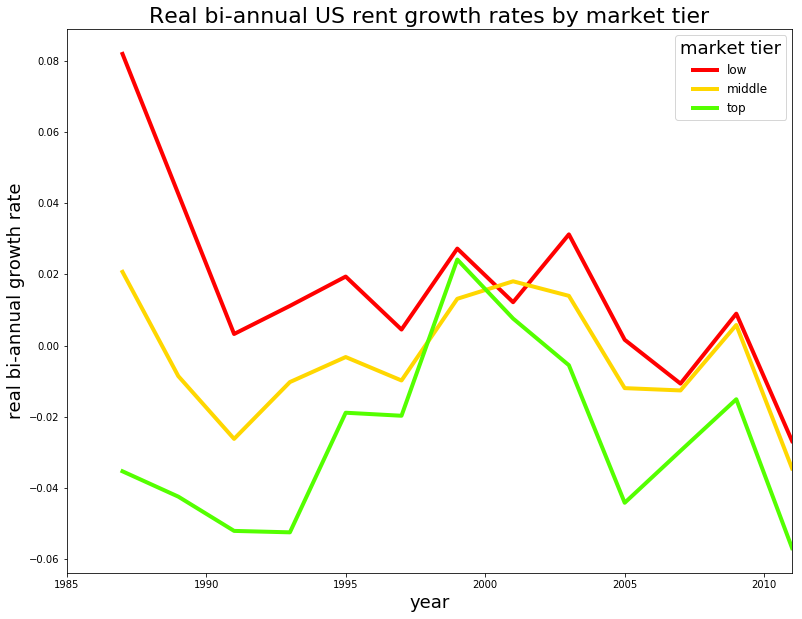

In [54]:
growths = df.groupby(['tier','year']).rrentChange.mean().unstack(level=0)
growths.plot(figsize = (13,10),linewidth=4,cmap='prism')
plt.title("Real bi-annual US rent growth rates by market tier", fontsize=22)
plt.ylabel("real bi-annual growth rate",fontsize=18)
plt.xlabel('year', fontsize=18)
plt.legend(title='market tier',title_fontsize=18, fontsize=12)
plt.savefig("/".join([data_path, 'rrentChange.png']), bbox_inches='tight',pad_inches=0)

In [55]:
tierCounts = df.groupby(['tier','year']).rrent.count().unstack(level=0)
tierCounts.loc[:,'total'] = tierCounts.sum(axis=1)
np.divide(tierCounts, tierCounts.total.values.reshape(14,1)).round(2)

tier,low,middle,top,total
year,,,,
1985,0.26,0.49,0.25,1.0
1987,0.24,0.50,0.26,1.0
1989,0.22,0.49,0.28,1.0
1991,0.22,0.49,0.29,1.0
1993,0.22,0.49,0.29,1.0
1995,0.23,0.49,0.29,1.0
1997,0.21,0.48,0.30,1.0
1999,0.22,0.49,0.30,1.0
2001,0.20,0.49,0.31,1.0


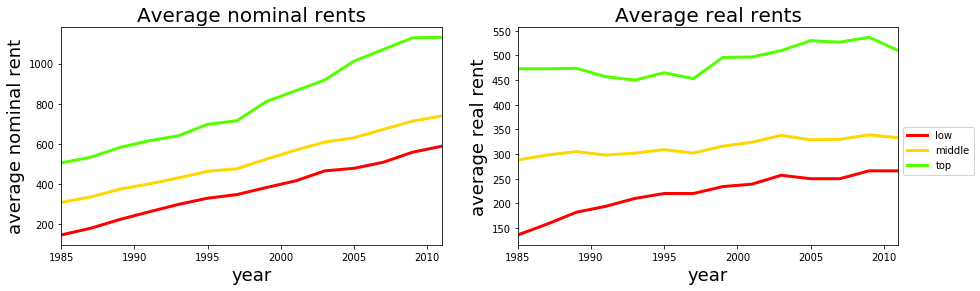

In [56]:
fig,axes = plt.subplots(1,2,sharex=True)

df.groupby(['tier','year']).rent.mean().round(0).unstack(0).plot(cmap='prism',linewidth=3,ax=axes[0],legend=False)
df.groupby(['tier','year']).rrent.mean().round(0).unstack(0).plot(cmap='prism',linewidth=3,ax=axes[1])

axes[0].set_xlabel('year', fontsize=18)
axes[0].set_ylabel('average nominal rent', fontsize=18)
axes[0].set_title("Average nominal rents", fontsize=20)

axes[1].set_xlabel('year', fontsize=18)
axes[1].set_ylabel('average real rent', fontsize=18)
axes[1].set_title("Average real rents", fontsize=20)

axes[1].legend(loc='lower left', bbox_to_anchor=(1, 0.3))
fig.set_figwidth(15)
plt.savefig("/".join([data_path, 'annualRents.png']), bbox_inches='tight',pad_inches=0)

Text(0.5, 1.0, 'Share of new units by tier')

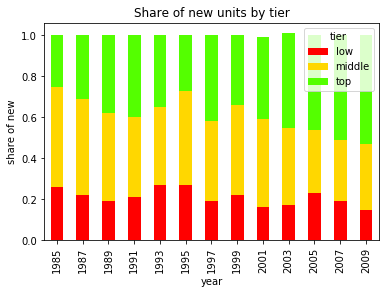

In [57]:
# Exit and Enter of units
exits = df.groupby(['year','tier']).firstYear.sum().unstack(level=1)
exits = exits.iloc[:-1,:]
exits.loc[:,'total'] = exits.sum(axis=1)
ax = np.divide(exits,exits.total.values.reshape(exits.shape[0],1)).round(2).iloc[:,:-1].plot(cmap='prism',kind='bar',stacked=True)
ax.set_ylabel('share of new')
ax.set_title("Share of new units by tier")

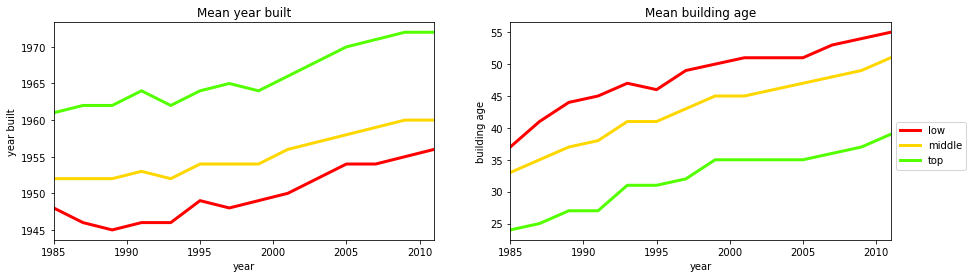

In [58]:
fig,axes = plt.subplots(1,2,sharex=True)
df.groupby(['tier','year']).built.mean().unstack(level=0).round(0).plot(cmap='prism',linewidth=3,ax=axes[0],legend=False)
df.groupby(['tier','year']).bldage.mean().round(0).unstack(0).plot(cmap='prism',linewidth=3,ax=axes[1])

axes[0].set_ylabel('year built')
axes[0].set_title("Mean year built")

axes[1].set_ylabel('building age')
axes[1].set_title("Mean building age")

axes[1].legend(loc='lower left', bbox_to_anchor=(1, 0.3))
fig.set_figwidth(15)

In [59]:
df.tail()

,control,year,moved,rntdatey,mktrent,rent,rent_updated,trent,trent0,trent1,...,bottomQuart,upperQuart,bottomHalf,topHalf,csi,r,pti_mean,pti_top,pti_all,tier
178097,7.467301e+11,2005,2005.0,2005.0,1.0,950.0,950.0,950.0,NaN,950.0,...,0,1,False,1,171.782333,0.058667,7.567662,5.729457,6.737098,top
178098,7.467301e+11,2007,2006.0,2007.0,1.0,1000.0,1000.0,1000.0,950.0,1000.0,...,0,1,False,1,179.950167,0.063373,8.294649,6.491392,7.425208,top
178099,7.467301e+11,2009,2007.0,2007.0,NaN,1000.0,NaN,NaN,NaN,NaN,...,0,1,False,1,148.558917,0.050365,6.772886,5.048369,6.339024,top
178100,7.475483e+11,2007,2006.0,2006.0,NaN,1100.0,NaN,NaN,NaN,NaN,...,0,1,False,1,179.950167,0.063373,7.859773,7.545950,7.905855,top
178101,7.475483e+11,2009,2008.0,2008.0,NaN,914.0,NaN,NaN,NaN,NaN,...,0,1,False,1,148.558917,0.050365,7.263888,5.505201,7.538367,top


# Run Models

In [60]:
df.groupby(['year','tier']).rrentChange.mean().unstack(level=1).round(3)*100

tier,low,middle,top
year,,,
1985,NaN,NaN,NaN
1987,8.2,2.1,-3.5
1989,4.3,-0.9,-4.2
1991,0.3,-2.6,-5.2
1993,1.1,-1.0,-5.3
1995,1.9,-0.3,-1.9
1997,0.5,-1.0,-2.0
1999,2.7,1.3,2.4
2001,1.2,1.8,0.8


In [61]:
df.loc[:,'npti'] = df.pti_top/10

In [62]:
fitDict = {}
fitDict['PTItopupperQuart'] = runRegression('rrentChange','C(smsa)+pti_top+C(samehh)',df.loc[(df.year>1985) & (df.upperQuart==1)])
fitDict['nPTIupperQuart'] = runRegression('rrentChange','C(smsa)+npti+C(samehh)',df.loc[(df.year>1985) & (df.upperQuart==1)])
fitDict['yearFE'] = runRegression('rrentChange','topHalf+C(smsa)+C(year)+C(samehh)',df.loc[df.year>1985])
fitDict['post87'] = runRegression('rrentChange','topHalf+C(smsa)+C(year)+C(samehh)',df.loc[df.year>1987])
fitDict['csi'] = runRegression('rrentChange','topHalf+C(smsa)+C(samehh)+np.log(csi)',df.loc[df.year>1985])
fitDict['upperQuart'] = runRegression('rrentChange','bottomQuart+upperQuart+C(smsa)+C(samehh)',df.loc[df.year>1985])
fitDict['PTIupperQuart'] = runRegression('rrentChange','C(smsa)+r*pti_top+C(samehh)',df.loc[(df.year>1985) & (df.upperQuart==1)])
fitDict['PTIbottomQuart'] = runRegression('rrentChange','C(smsa)+r*pti_top+C(samehh)',df.loc[(df.year>1985) & (df.bottomQuart==1)])
#fitDict['bldAge'] = runRegression('rrentChange','upperQuart+C(smsa)+C(year)+C(samehh)+np.sqrt(bldage)',df.loc[(df.year>1985) & (df.smsa!=9999)])
fitDict['knownSMSA'] = runRegression('rrentChange','bottomQuart+upperQuart+C(smsa)+C(year)+C(samehh)',df.loc[(df.year>1985) & (df.smsa!=9999)])
fitDict['consistentPanel'] = runRegression('rrentChange','bottomQuart+upperQuart+C(smsa)+C(samehh)',df.loc[(df.year>1985) & (df.smsa!=9999) & (df.firstYear<=1987)])

In [63]:
outTable = extractResults(['topHalf','upperQuart','bottomQuart','Intercept','C(samehh)[T.1.0]','np.log(csi)','r:pti_top','npti','pti_top'],fitDict)
outTable.index

Index(['C(samehh)[T.1.0]', 'Intercept', 'R^2 adj', 'bottomQuart', 'condNum',
       'nObs', 'np.log(csi)', 'npti', 'pti_top', 'r:pti_top', 'topHalf',
       'upperQuart'],
      dtype='object')

In [64]:
# Blog version

cols = ['upperQuart','PTIupperQuart']
coeffOrder = ['Intercept','upperQuart','bottomQuart','r:pti_top','C(samehh)[T.1.0]','nObs','R^2 adj','condNum']
blogT = outTable.loc[coeffOrder,cols].rename(columns = {'upperQuart':'rent change','PTIupperQuart':'high-tier rent change'})
blogT.rename({'upperQuart':'higher-tier','bottomQuart':'low-tier','pti_top':'pti','C(samehh)[T.1.0]':'same HH'})

,rent change,high-tier rent change
Intercept,0.020 (0.254),-0.019 (0.597)
higher-tier,-0.023 (0.000),
low-tier,0.021 (0.000),
r:pti_top,,0.035 (0.520)
same HH,-0.014 (0.000),-0.005 (0.064)
nObs,145163,37111
R^2 adj,0.01,0
condNum,425,1743


In [66]:
outTable.loc[['Intercept','topHalf','upperQuart','bottomQuart','C(samehh)[T.1.0]','np.log(csi)','r:pti_top','npti','pti_top','nObs','R^2 adj','condNum']]

,PTItopupperQuart,nPTIupperQuart,yearFE,post87,csi,upperQuart,PTIupperQuart,PTIbottomQuart,knownSMSA,consistentPanel
Intercept,-0.022 (0.476),-0.022 (0.476),0.064 (0.000),0.037 (0.049),0.076 (0.000),0.020 (0.254),-0.019 (0.597),-0.034 (0.513),0.058 (0.001),0.020 (0.251)
topHalf,,,-0.030 (0.000),-0.027 (0.000),-0.030 (0.000),,,,,
upperQuart,,,,,,-0.023 (0.000),,,-0.022 (0.000),-0.022 (0.000)
bottomQuart,,,,,,0.021 (0.000),,,0.022 (0.000),0.022 (0.000)
C(samehh)[T.1.0],-0.004 (0.070),-0.004 (0.070),-0.019 (0.000),-0.019 (0.000),-0.014 (0.000),-0.014 (0.000),-0.005 (0.064),-0.022 (0.000),-0.022 (0.000),-0.015 (0.000)
np.log(csi),,,,,-0.009 (0.000),,,,,
r:pti_top,,,,,,,0.035 (0.520),0.077 (0.346),,
npti,,0.003 (0.687),,,,,,,,
pti_top,0.000 (0.687),,,,,,-0.001 (0.692),-0.000 (0.960),,
nObs,37111,37111,145163,136139,145163,145163,37111,26232,90017,90017
